- repository:
    + https://github.com/komo-fr/networkx2bokeh_note/blob/master/notebooks/draft_from_networkx_for_fixed_layout.ipynb
- nbviewer:
    + http://nbviewer.jupyter.org/github/komo-fr/networkx2bokeh_note/blob/master/notebooks/draft_from_networkx_for_fixed_layout.ipynb

In [1]:
import sys

import networkx as nx
import matplotlib.pyplot as plt
import bokeh
from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, StaticLayoutProvider
from bokeh.models.graphs import from_networkx
from bokeh.models.sources import ColumnDataSource
from bokeh.models.renderers import GraphRenderer
from bokeh.models.graphs import StaticLayoutProvider

%matplotlib inline

In [2]:
print('NetworkX: {}'.format(nx.__version__))
print('Bokeh: {}'.format(bokeh.__version__))
print('Python: {}.{}.{}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))

NetworkX: 2.2
Bokeh: 1.0.0dev11
Python: 3.6.2


# Prepare Data

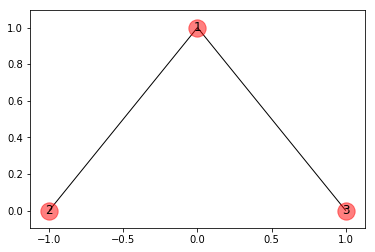

In [3]:
# prepare graph data
node_datasource = [1, 2, 3]
edge_datasource = [(1, 2), (1, 3)]

G = nx.Graph()
G.add_nodes_from(node_datasource)
G.add_edges_from(edge_datasource)

# prepare position data
fixed_layout = {1: [0, 1],
                2: [-1, 0],
                3: [1, 0]}

# show 
fig = plt.figure()
nx.draw_networkx_nodes(G, pos=fixed_layout, alpha=0.5)
nx.draw_networkx_labels(G, pos=fixed_layout)
nx.draw_networkx_edges(G, pos=fixed_layout)
plt.show()

# Convert to Bokeh with Fixed Layout

## Before
- from_networkx:
    - https://github.com/bokeh/bokeh/blob/master/bokeh/models/graphs.py#L35-L109
       
Currently (ver 0.13.0) Bokeh, from_networkx function always requires a layout function.

In [4]:
graph_renderer = from_networkx(G)

# show
plot = Plot(plot_width=300, plot_height=300,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

TypeError: from_networkx() missing 1 required positional argument: 'layout_function'

## After

### Approach 1. Add a new function for graphs with fixed layout

In [5]:
# !!! Add a new function apart from the existing from_networkx !!! 
def from_networkx_with_layout(graph, graph_layout):
        '''
        Generate a GraphRenderer from a networkx.Graph object and networkx
        layout function. Any keyword arguments will be passed to the
        layout function.
        Args:
            graph (networkx.Graph) : a networkx graph to render
            graph_layout (dict) : layout of a networkx graph
        Returns:
            instance (GraphRenderer)
        .. warning::
            Only two dimensional layouts are currently supported.
        .. warning::
            Node attributes labeled 'index' and edge attributes labeled 'start' or 'end' are ignored.
            If you want to convert these attributes, please re-label them to other names.
        '''

        # inline import to prevent circular imports
        # !!! Comment out once to run on Jupyter Notebook. !!!
        # !!! In fact, the two lines of code are executed. !!!
        # from .models.renderers import GraphRenderer
        # from ..models.graphs import StaticLayoutProvider

        # !!! Lines 27-68 are exactly the same as existing from_networkx. !!!
        # !!! Therefore, it would be better to put it out as a different function. !!!
        node_dict = dict()
        node_attr_keys = [attr_key for node in list(graph.nodes(data=True))
                          for attr_key in node[1].keys()]
        node_attr_keys = list(set(node_attr_keys))

        for attr_key in node_attr_keys:
            node_dict[attr_key] = [node_attr[attr_key] if attr_key in node_attr.keys() else None
                                   for _, node_attr
                                   in graph.nodes(data=True)]

        if 'index' in node_attr_keys:
            from warnings import warn
            warn("Converting node attributes labeled 'index' are skipped. "
                 "If you want to convert these attributes, please re-label with other names.")

        node_dict['index'] = list(graph.nodes())

        # Convert edge attributes
        edge_dict = dict()
        edge_attr_keys = [attr_key for edge in graph.edges(data=True)
                          for attr_key in edge[2].keys()]
        edge_attr_keys = list(set(edge_attr_keys))

        for attr_key in edge_attr_keys:
            edge_dict[attr_key] = [edge_attr[attr_key] if attr_key in edge_attr.keys() else None
                                   for _, _, edge_attr
                                   in graph.edges(data=True)]

        if 'start' in edge_attr_keys or 'end' in edge_attr_keys:
            from warnings import warn
            warn("Converting edge attributes labeled 'start' or 'end' are skipped. "
                 "If you want to convert these attributes, please re-label them with other names.")

        edge_dict['start'] = [x[0] for x in graph.edges()]
        edge_dict['end'] = [x[1] for x in graph.edges()]

        node_source = ColumnDataSource(data=node_dict)
        edge_source = ColumnDataSource(data=edge_dict)

        graph_renderer = GraphRenderer()
        graph_renderer.node_renderer.data_source.data = node_source.data
        graph_renderer.edge_renderer.data_source.data = edge_source.data
        
        # !!! Set layout specified by argument !!!
        graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

        return graph_renderer

#### Usage Example
- See also the cell of <a hreF="http://nbviewer.jupyter.org/github/komo-fr/networkx2bokeh_note/blob/master/notebooks/draft_from_networkx_for_fixed_layout.ipynb#Prepare-Data">**"Prepare Data"</a>**.

In [6]:
# !!! Call a new function for fixed layout!!! 
graph_renderer = from_networkx_with_layout(G, fixed_layout)

# show
plot = Plot(plot_width=300, plot_height=300,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

### Approach 2. Update from_networkx to handle both fixed layout and layout function

In [7]:
# !!! graph_layout is a dict or function. !!! 
# !!! It is't backward compatible with 0.13.0 since the argument name change. !!!
def from_networkx(graph, graph_layout, **kwargs):
        '''
        Generate a GraphRenderer from a networkx.Graph object and networkx
        layout function. Any keyword arguments will be passed to the
        layout function.
        Args:
            graph (networkx.Graph) : a networkx graph to render
            layout_function (function) : a networkx layout function
        Returns:
            instance (GraphRenderer)
        .. warning::
            Only two dimensional layouts are currently supported.
        .. warning::
            Node attributes labeled 'index' and edge attributes labeled 'start' or 'end' are ignored.
            If you want to convert these attributes, please re-label them to other names.
        '''

        # inline import to prevent circular imports
        # !!! Comment out once to run on Jupyter Notebook. !!!
        # !!! In fact, the two lines of code are executed. !!!
        # from .models.renderers import GraphRenderer
        # from ..models.graphs import StaticLayoutProvider

        # !!! Lines 27-68 are exactly the same as existing from_networkx. !!!
        node_dict = dict()
        node_attr_keys = [attr_key for node in list(graph.nodes(data=True))
                          for attr_key in node[1].keys()]
        node_attr_keys = list(set(node_attr_keys))

        for attr_key in node_attr_keys:
            node_dict[attr_key] = [node_attr[attr_key] if attr_key in node_attr.keys() else None
                                   for _, node_attr
                                   in graph.nodes(data=True)]

        if 'index' in node_attr_keys:
            from warnings import warn
            warn("Converting node attributes labeled 'index' are skipped. "
                 "If you want to convert these attributes, please re-label with other names.")

        node_dict['index'] = list(graph.nodes())

        # Convert edge attributes
        edge_dict = dict()
        edge_attr_keys = [attr_key for edge in graph.edges(data=True)
                          for attr_key in edge[2].keys()]
        edge_attr_keys = list(set(edge_attr_keys))

        for attr_key in edge_attr_keys:
            edge_dict[attr_key] = [edge_attr[attr_key] if attr_key in edge_attr.keys() else None
                                   for _, _, edge_attr
                                   in graph.edges(data=True)]

        if 'start' in edge_attr_keys or 'end' in edge_attr_keys:
            from warnings import warn
            warn("Converting edge attributes labeled 'start' or 'end' are skipped. "
                 "If you want to convert these attributes, please re-label them with other names.")

        edge_dict['start'] = [x[0] for x in graph.edges()]
        edge_dict['end'] = [x[1] for x in graph.edges()]

        node_source = ColumnDataSource(data=node_dict)
        edge_source = ColumnDataSource(data=edge_dict)

        graph_renderer = GraphRenderer()
        graph_renderer.node_renderer.data_source.data = node_source.data
        graph_renderer.edge_renderer.data_source.data = edge_source.data
        
        #!!! if graph_layout is a function, it is called to calculate a layout. !!!
        if callable(graph_layout):
            graph_layout = graph_layout(graph, **kwargs)
        
        graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)
        
        return graph_renderer

#### Usage Example
- See also the cell of <a hreF="http://nbviewer.jupyter.org/github/komo-fr/networkx2bokeh_note/blob/master/notebooks/draft_from_networkx_for_fixed_layout.ipynb#Prepare-Data">**"Prepare Data"</a>**.

In [8]:
# !!! Call from_networkx with fixed layout !!! 
graph_renderer = from_networkx(G, fixed_layout)

# show
plot = Plot(plot_width=300, plot_height=300,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

In [9]:
# !!! Call from_networkx with layout function !!! 
graph_renderer = from_networkx(G, nx.spring_layout)

# show
plot = Plot(plot_width=300, plot_height=300,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

### Approach 3. Update from_networkx so that  it can be called without a layout function

In [10]:
# !!! Make layout_function an optional argument !!! 
def from_networkx(graph, layout_function=None, **kwargs):
        '''
        Generate a GraphRenderer from a networkx.Graph object and networkx
        layout function. Any keyword arguments will be passed to the
        layout function.
        Args:
            graph (networkx.Graph) : a networkx graph to render
            layout_function (function) : a networkx layout function
        Returns:
            instance (GraphRenderer)
        .. warning::
            Only two dimensional layouts are currently supported.
        .. warning::
            Node attributes labeled 'index' and edge attributes labeled 'start' or 'end' are ignored.
            If you want to convert these attributes, please re-label them to other names.
        '''

        # inline import to prevent circular imports
        # !!! Comment out once to run on Jupyter Notebook. !!!
        # !!! In fact, the two lines of code are executed. !!!
        # from .models.renderers import GraphRenderer
        # from ..models.graphs import StaticLayoutProvider

        # !!! Lines 26-67 are exactly the same as existing from_networkx. !!!
        node_dict = dict()
        node_attr_keys = [attr_key for node in list(graph.nodes(data=True))
                          for attr_key in node[1].keys()]
        node_attr_keys = list(set(node_attr_keys))

        for attr_key in node_attr_keys:
            node_dict[attr_key] = [node_attr[attr_key] if attr_key in node_attr.keys() else None
                                   for _, node_attr
                                   in graph.nodes(data=True)]

        if 'index' in node_attr_keys:
            from warnings import warn
            warn("Converting node attributes labeled 'index' are skipped. "
                 "If you want to convert these attributes, please re-label with other names.")

        node_dict['index'] = list(graph.nodes())

        # Convert edge attributes
        edge_dict = dict()
        edge_attr_keys = [attr_key for edge in graph.edges(data=True)
                          for attr_key in edge[2].keys()]
        edge_attr_keys = list(set(edge_attr_keys))

        for attr_key in edge_attr_keys:
            edge_dict[attr_key] = [edge_attr[attr_key] if attr_key in edge_attr.keys() else None
                                   for _, _, edge_attr
                                   in graph.edges(data=True)]

        if 'start' in edge_attr_keys or 'end' in edge_attr_keys:
            from warnings import warn
            warn("Converting edge attributes labeled 'start' or 'end' are skipped. "
                 "If you want to convert these attributes, please re-label them with other names.")

        edge_dict['start'] = [x[0] for x in graph.edges()]
        edge_dict['end'] = [x[1] for x in graph.edges()]

        node_source = ColumnDataSource(data=node_dict)
        edge_source = ColumnDataSource(data=edge_dict)

        graph_renderer = GraphRenderer()
        graph_renderer.node_renderer.data_source.data = node_source.data
        graph_renderer.edge_renderer.data_source.data = edge_source.data
        
        # !!! Even if there is no layout_function, execute the function to the end !!!
        if layout_function:
            graph_layout = layout_function(graph, **kwargs)
            graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)
        else:
            from warnings import warn
            warn("Graph layout is not set. Please set the graph layout before drawing.")

        return graph_renderer


#### Usage Example
- See also the cell of <a hreF="http://nbviewer.jupyter.org/github/komo-fr/networkx2bokeh_note/blob/master/notebooks/draft_from_networkx_for_fixed_layout.ipynb#Prepare-Data">**"Prepare Data"</a>**.

In [12]:
# !!! Call from_networkx without layout_function !!! 
graph_renderer = from_networkx(G)

# !!! Set fixed layout directly to layout_provider !!!
graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=fixed_layout)

# show
plot = Plot(plot_width=300, plot_height=300,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

/Users/tomoko/anaconda/envs/nx2_env/lib/python3.6/site-packages/ipykernel/__main__.py:75: UserWarning: Graph layout is not set. Please set the graph layout before drawing.


Loading BokehJS ...